# ETT

Required packets

In [1]:
from darts import TimeSeries
from darts.metrics import mape, mse, mae
from darts.models import NaiveMean, NaiveSeasonal, NaiveDrift, NaiveMovingAverage, RandomForest, LinearRegressionModel, AutoARIMA, Theta, StatsForecastAutoETS, Prophet, NBEATSModel, NLinearModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import Scaler, StaticCovariatesTransformer, MissingValuesFiller, InvertibleMapper
import sklearn
from sklearn import preprocessing
from darts.timeseries import concatenate

/home/filo/University/Thesis/Algorithm/wav_env/lib/python3.11/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


Load dataset as a series and prepare it by splitting into train and test

Dataset does not contain NaN values


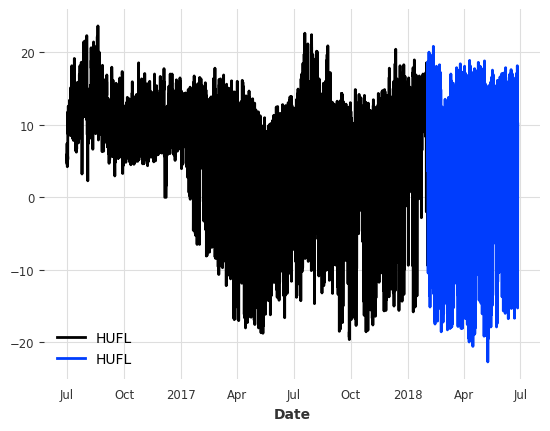

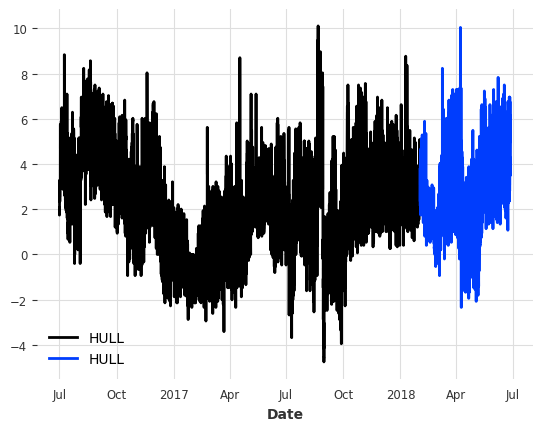

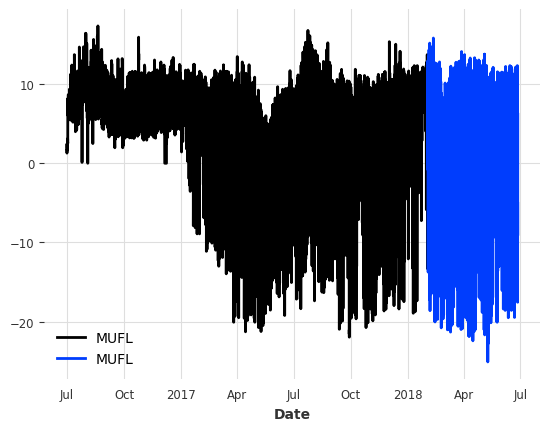

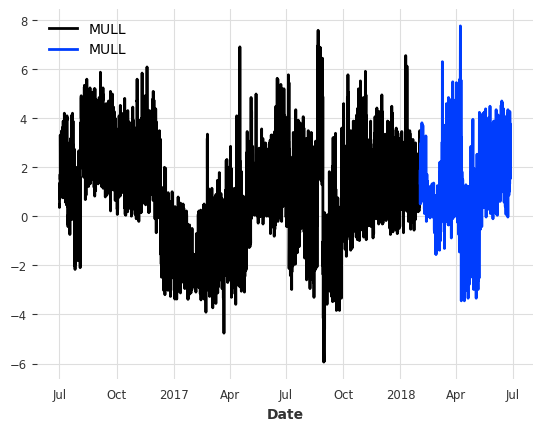

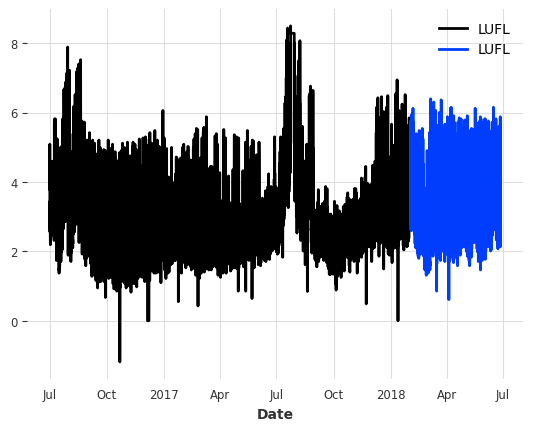

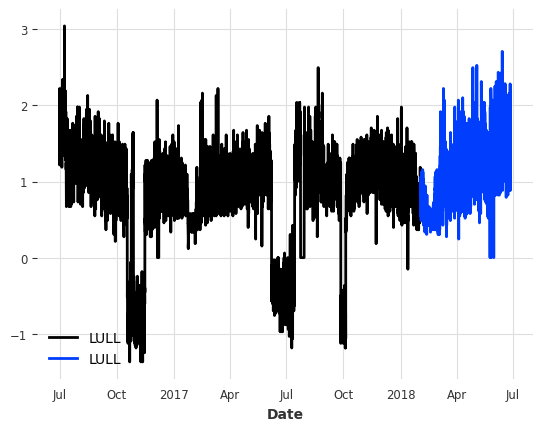

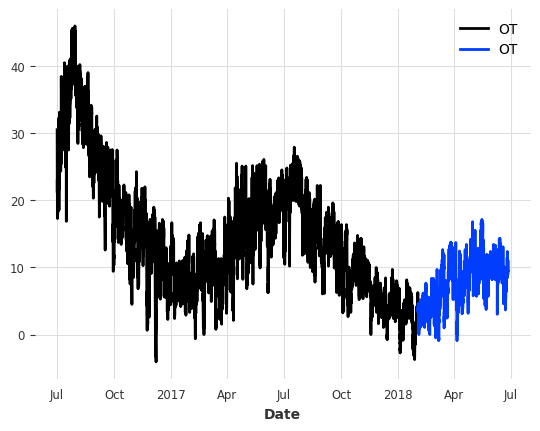

In [2]:
df = pd.read_csv("../dataset/ETT/ETTh1.csv", header=0, index_col=0)
# Change to the appropriate format
df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S')
df.index.name = 'Date'
# Check for NaN values
nan_check = df.isna().any().any()

if nan_check:
    print("Dataset contains NaN values")
    upsampled= df.resample('D').mean()
    series = upsampled.interpolate(method = 'linear')
    series = TimeSeries.from_dataframe(series)
else:
    print("Dataset does not contain NaN values")
    series = TimeSeries.from_dataframe(df)
train, test = series.split_after(0.80)
if series.is_univariate:
  train.plot()
  test.plot()
else:
  header = train.columns
  for column in header:
    try:
      train[column].plot()
      test[column].plot()
      plt.show()
    except KeyError as e:
      print(e)



Create a list of time series obj slicing the dataset into parts identified with wavelet

In [3]:
def train_test_split(lst, percentage=80.0):
    # Calcola il numero di elementi da prendere
    num_elements = int(len(lst) * (percentage / 100.0))
    print(num_elements)
    # Prendi il numero desiderato di elementi
    return lst[:num_elements], lst[num_elements:]

df = pd.read_csv("../Dataset Preparation/final_dataset.csv", header=0, index_col=0)
df.index = pd.to_datetime(df.index)
series = TimeSeries.from_dataframe(df, time_col=0)
time_index = series.time_index
header = series.columns
lst_series = []
for column in header:
    tmp_series = series.univariate_component(column).values()
    train_w, test_w = train_test_split(tmp_series, 80.0)
    start_index = 1
    for i in range(0, len(train_w)-1):
        if np.isnan(train_w[i]) and np.isnan(train_w[i+1]) == False:
            start_index = i + 1
        if np.isnan(train_w[i]) == False and np.isnan(train_w[i+1]) and start_index != 0:
            end_index = i
            if end_index - start_index > 24:
                res = series.univariate_component(column).slice(start_ts=time_index[start_index], end_ts=time_index[end_index])
                lst_series.append(res)
            start_index = 0
    if column == 'HUFL':
        test_HUFL = test_w
    if column == 'HULL':
        test_HULL = test_w
    if column == 'MUFL':
        test_MUFL = test_w
    if column == 'MULL':
        test_MULL = test_w
    if column == 'LUFL':
        test_LUFL = test_w
    if column == 'LULL':
        test_LULL = test_w
    if column == 'OT':
        test_OT = test_w

13936
13936
13936
13936
13936
13936
13936


In [13]:
print(len(lst_series))
print(len(test_HUFL))
print(len(test_HULL))
print(len(test_MUFL))
print(len(test_MULL))
print(len(test_LUFL))
print(len(test_LULL))
print(len(test_OT))

88
3484
3484
3484
3484
3484
3484
3484


## Deep Learning models

In [4]:
model6 = NBEATSModel(
    input_chunk_length = 12,
    output_chunk_length= 2,
    num_stacks = 3,
    num_blocks = 2,
    num_layers = 3,
    layer_widths = 32,
    n_epochs = 150,
    batch_size = 12,
)

model7 = NLinearModel(
    input_chunk_length = 12,
    output_chunk_length=2,
    n_epochs= 150,
)

models = {
    "NBEATS": model6,
    "NLinear": model7
}

### FIT - PREDICT

Forecast with fit predict

In [ ]:
# mae_list = []
# mse_list = []
# fig = plt.figure(figsize=(18, 14))
# row = 0
# for i, (name, model) in enumerate(models.items()):
#   print(name)
#   row += 1
#   for index, column in enumerate(header):
#     tmp_train = train.univariate_component(column)
#     tmp_test = test.univariate_component(column)
#     model.fit(series=tmp_train)
#     predictions = model.predict(n = len(test))
#     mae_score = round(mae(tmp_test, predictions), 5)
#     mae_list.append([mae_score, name, 'std'])
#     mse_score = round(mse(tmp_test, predictions), 5)
#     mse_list.append([mse_score, name, 'std'])
#     index += i + row
#     fig.add_subplot(2, 2, index) # method, variable, position
#     tmp_train.plot(label="train"); tmp_test.plot(label="test"); predictions.plot(label=name)
#     plt.title(f"Method: {name}, Variable: {column} (std)"); plt.legend()
# fig.tight_layout()
# plt.savefig('nn_wo.png')
# plt.show()

# fig = plt.figure(figsize=(16, 10))
# row = 0
# for i, (name, model) in enumerate(models.items()):
#   print(name)
#   row += 1
#   for index, column in enumerate(header):
#     if column == ' PM10':
#       model.fit(series=train_10)
#       predictions = model.predict(n = len(test))
#       mae_score = round(mae(test_10, predictions), 5)
#       mae_list.append([mae_score, name, 'PM10'])
#       mse_score = round(mse(test_10, predictions), 5)
#       mse_list.append([mse_score, name, 'PM10'])
#     elif column == ' PM2.5':
#       model.fit(series=train_25)
#       predictions = model.predict(n = len(test))
#       mae_score = round(mae(test_25, predictions), 5)
#       mae_list.append([mae_score, name, 'PM25'])
#       mse_score = round(mse(test_25, predictions), 5)
#       mse_list.append([mse_score, name, 'PM25'])

#     index += i + row
#     fig.add_subplot(2, 2, index)
#     if column == ' PM10':
#       train.plot(label="train"); test_10.plot(label="test"); predictions.plot(label=name)
#     elif column == ' PM2.5':
#       train.plot(label="train"); test_25.plot(label="test"); predictions.plot(label=name)
#     plt.title(f"Method: {name}, Variable: {column} with sample selection"); plt.legend()
# fig.tight_layout()
# plt.savefig('nn_w.png')
# plt.show()

In [ ]:
# print(mae_list)
# print(mse_list)

Training with a list of time series, recreating backtest without selection on test

In [ ]:
mae_list = []
mse_list = []
fig = plt.figure(figsize=(18, 14))
row = 0
for i, (name, model) in enumerate(models.items()):
  print(name)
  row += 1
  for index, column in enumerate(header):
    tmp_train = train.univariate_component(column)
    tmp_test = test.univariate_component(column)
    predictions = tmp_train[-1]
    # devo scorrere test  e aggiungerli a tmp_train
    for pred in range(0, 3480, 24):
      model.fit(series=tmp_train)
      prediction = model.predict(n = 24, series=tmp_train)
      predictions = predictions.append(prediction)
      pred = tmp_test.get_timestamp_at_point(pred)
      tmp_add = tmp_test.slice_n_points_after(pred, 24)
      tmp_train = tmp_train.append(tmp_add)
    mae_score = round(mae(tmp_test, predictions), 5)
    mae_list.append([mae_score, name, f'std {column}'])
    mse_score = round(mse(tmp_test, predictions), 5)
    mse_list.append([mse_score, name, f'std {column}'])
    index += i + row
    fig.add_subplot(2, 7, index) # method, variable, position
    tmp_train.plot(label="train"); tmp_test.plot(label="test"); predictions.plot(label=name)
    plt.title(f"Method: {name}, Variable: {column} (std)"); plt.legend()
fig.tight_layout()
plt.savefig('nn_wo.png')
plt.show()

fig = plt.figure(figsize=(16, 10))
row = 0
for i, (name, model) in enumerate(models.items()):
  print(name)
  row += 1
  for index, column in enumerate(header):
    tmp_train = train.univariate_component(column)
    tmp_test = test.univariate_component(column)
    predictions = tmp_train[-1]
    for pred in range(0, 3480, 24):
      model.fit(series = lst_series)
      prediction = model.predict(n = 24, series = tmp_train)
      predictions = predictions.append(prediction)
      pred = tmp_test.get_timestamp_at_point(pred)
      tmp_add = tmp_test.slice_n_points_after(pred, 24)
      lst_series.append(tmp_add)
      tmp_train = tmp_train.append(tmp_add)
    if column == 'HUFL':
      mae_score = round(mae(tmp_test, predictions), 5)
      mae_list.append([mae_score, name, 'HUFL'])
      mse_score = round(mse(tmp_test, predictions), 5)
      mse_list.append([mse_score, name, 'HUFL'])
    elif column == 'HULL':
      mae_score = round(mae(tmp_test, predictions), 5)
      mae_list.append([mae_score, name, 'HULL'])
      mse_score = round(mse(tmp_test, predictions), 5)
      mse_list.append([mse_score, name, 'HULL'])
    elif column == 'MUFL':
      mae_score = round(mae(tmp_test, predictions), 5)
      mae_list.append([mae_score, name, 'MUFL'])
      mse_score = round(mse(tmp_test, predictions), 5)
      mse_list.append([mse_score, name, 'MUFL'])
    elif column == 'MULL':
      mae_score = round(mae(tmp_test, predictions), 5)
      mae_list.append([mae_score, name, 'MULL'])
      mse_score = round(mse(tmp_test, predictions), 5)
      mse_list.append([mse_score, name, 'MULL'])
    elif column == 'LUFL':
      mae_score = round(mae(tmp_test, predictions), 5)
      mae_list.append([mae_score, name, 'LUFL'])
      mse_score = round(mse(tmp_test, predictions), 5)
      mse_list.append([mse_score, name, 'LUFL'])
    elif column == 'LULL':
      mae_score = round(mae(tmp_test, predictions), 5)
      mae_list.append([mae_score, name, 'LULL'])
      mse_score = round(mse(tmp_test, predictions), 5)
      mse_list.append([mse_score, name, 'LULL'])
    elif column == 'OT':
      mae_score = round(mae(tmp_test, predictions), 5)
      mae_list.append([mae_score, name, 'OT'])
      mse_score = round(mse(tmp_test, predictions), 5)
      mse_list.append([mse_score, name, 'OT'])

    index += i + row
    fig.add_subplot(2, 7, index)
    train.univariate_component(column).plot(label="train"); tmp_test.plot(label="test"); predictions.plot(label=name)
    plt.title(f"Method: {name}, Variable: {column} with sample selection"); plt.legend()
fig.tight_layout()
plt.savefig('nn_w.png')
plt.show()

In [ ]:
print(mae_list)
print(mse_list)

[[15.56781, 'NBEATS', 'std'], [11.58824, 'NBEATS', 'std'], [15.80173, 'NLinear', 'std'], [11.46498, 'NLinear', 'std'], [15.21392, 'NBEATS', 'PM10'], [11.6576, 'NBEATS', 'PM25'], [14.97233, 'NLinear', 'PM10'], [12.01986, 'NLinear', 'PM25']]
[[345.83003, 'NBEATS', 'std'], [196.71772, 'NBEATS', 'std'], [371.68352, 'NLinear', 'std'], [196.24202, 'NLinear', 'std'], [357.23528, 'NBEATS', 'PM10'], [211.7545, 'NBEATS', 'PM25'], [334.401, 'NLinear', 'PM10'], [206.36849, 'NLinear', 'PM25']]


Manual backtesting with list of time series, but with selection on test

In [ ]:
mae_list = []
mse_list = []
fig = plt.figure(figsize=(18, 14))
row = 0
for i, (name, model) in enumerate(models.items()):
  print(name)
  row += 1
  for index, column in enumerate(header):
    tmp_train = train.univariate_component(column)
    tmp_test = test.univariate_component(column)
    predictions = tmp_train[-1]
    # devo scorrere test 24 step e aggiungerli a tmp_train
    for pred in range(0, 3480, 24):
      model.fit(series=tmp_train)
      prediction = model.predict(n = 24, series=tmp_train)
      predictions = predictions.append(prediction)
      pred = tmp_test.get_timestamp_at_point(pred)
      tmp_add = tmp_test.slice_n_points_after(pred, 24)
      tmp_train = tmp_train.append(tmp_add)
    mae_score = round(mae(tmp_test, predictions), 5)
    mae_list.append([mae_score, name, f'std {column}'])
    mse_score = round(mse(tmp_test, predictions), 5)
    mse_list.append([mse_score, name, f'std {column}'])
    index += i + row
    fig.add_subplot(2, 7, index) # method, variable, position
    tmp_train.plot(label="train"); tmp_test.plot(label="test"); predictions.plot(label=name)
    plt.title(f"Method: {name}, Variable: {column} (std)"); plt.legend()
fig.tight_layout()
plt.savefig('nn_wo.png')
plt.show()

def nan_check(series, start, lenght):
  end = start + lenght
  for i in range(start, end):
      if np.isnan(series[i]):
          return True
  return False

fig = plt.figure(figsize=(16, 10))
row = 0
for i, (name, model) in enumerate(models.items()):
  print(name)
  row += 1
  for index, column in enumerate(header):
    tmp_train = train.univariate_component(column)
    tmp_test = test.univariate_component(column)
    predictions = tmp_train[-1]
    for pred in range(0, 3480, 24):
      model.fit(series = lst_series)
      prediction = model.predict(n = 24, series = tmp_train)
      predictions = predictions.append(prediction)
      pred_date = tmp_test.get_timestamp_at_point(pred)
      print(pred)
      tmp_add = tmp_test.slice_n_points_after(pred_date, 24)
      if column == 'HUFL':
        if nan_check(test_HUFL, pred, 24) == False:
          lst_series.append(tmp_add)
      elif column == 'HULL':
        if nan_check(test_HULL, pred, 24) == False:
          lst_series.append(tmp_add)
      elif column == 'MUFL':
        if nan_check(test_MUFL, pred, 24) == False:
          lst_series.append(tmp_add)
      elif column == 'MULL':
        if nan_check(test_MULL, pred, 24) == False:
          lst_series.append(tmp_add)
      elif column == 'LUFL':
        if nan_check(test_LUFL, pred, 24) == False:
          lst_series.append(tmp_add)
      elif column == 'LULL':
        if nan_check(test_LULL, pred, 24) == False:
          lst_series.append(tmp_add)
      elif column == 'OT':
        if nan_check(test_OT, pred, 24) == False:
          lst_series.append(tmp_add)
      tmp_train = tmp_train.append(tmp_add)
    if column == 'HUFL':
      mae_score = round(mae(tmp_test, predictions), 5)
      mae_list.append([mae_score, name, 'HUFL'])
      mse_score = round(mse(tmp_test, predictions), 5)
      mse_list.append([mse_score, name, 'HUFL'])
    elif column == 'HULL':
      mae_score = round(mae(tmp_test, predictions), 5)
      mae_list.append([mae_score, name, 'HULL'])
      mse_score = round(mse(tmp_test, predictions), 5)
      mse_list.append([mse_score, name, 'HULL'])
    elif column == 'MUFL':
      mae_score = round(mae(tmp_test, predictions), 5)
      mae_list.append([mae_score, name, 'MUFL'])
      mse_score = round(mse(tmp_test, predictions), 5)
      mse_list.append([mse_score, name, 'MUFL'])
    elif column == 'MULL':
      mae_score = round(mae(tmp_test, predictions), 5)
      mae_list.append([mae_score, name, 'MULL'])
      mse_score = round(mse(tmp_test, predictions), 5)
      mse_list.append([mse_score, name, 'MULL'])
    elif column == 'LUFL':
      mae_score = round(mae(tmp_test, predictions), 5)
      mae_list.append([mae_score, name, 'LUFL'])
      mse_score = round(mse(tmp_test, predictions), 5)
      mse_list.append([mse_score, name, 'LUFL'])
    elif column == 'LULL':
      mae_score = round(mae(tmp_test, predictions), 5)
      mae_list.append([mae_score, name, 'LULL'])
      mse_score = round(mse(tmp_test, predictions), 5)
      mse_list.append([mse_score, name, 'LULL'])
    elif column == 'OT':
      mae_score = round(mae(tmp_test, predictions), 5)
      mae_list.append([mae_score, name, 'OT'])
      mse_score = round(mse(tmp_test, predictions), 5)
      mse_list.append([mse_score, name, 'OT'])

    index += i + row
    fig.add_subplot(2, 7, index)
    train.univariate_component(column).plot(label="train"); tmp_test.plot(label="test"); predictions.plot(label=name)
    plt.title(f"Method: {name}, Variable: {column} with sample selection"); plt.legend()
fig.tight_layout()
plt.savefig('nn_w.png')
plt.show()

In [ ]:
print(mae_list)
print(mse_list)

[[15.93798, 'NBEATS', 'std  PM10'], [12.38527, 'NBEATS', 'std  PM2.5'], [15.69165, 'NLinear', 'std  PM10'], [11.41994, 'NLinear', 'std  PM2.5'], [19.43645, 'NBEATS', 'PM10'], [12.10657, 'NBEATS', 'PM25'], [14.74907, 'NLinear', 'PM10'], [11.94549, 'NLinear', 'PM25']]
[[413.83001, 'NBEATS', 'std  PM10'], [226.31969, 'NBEATS', 'std  PM2.5'], [364.57415, 'NLinear', 'std  PM10'], [194.94663, 'NLinear', 'std  PM2.5'], [571.98189, 'NBEATS', 'PM10'], [207.96186, 'NBEATS', 'PM25'], [328.19824, 'NLinear', 'PM10'], [206.95525, 'NLinear', 'PM25']]


### BACKTEST    

Backtest first try

In [ ]:
# mae_list = []
# mse_list = []
# fig = plt.figure(figsize=(18, 14))
# row = 0
# for i, (name, model) in enumerate(models.items()):
#   print(name)
#   row += 1
#   for index, column in enumerate(header):
#     tmp_series = series.univariate_component(column)
#     tmp_train = train.univariate_component(column)
#     tmp_test = test.univariate_component(column)
#     # Get predictions
#     prediction = model.historical_forecasts(series=tmp_series,
#                                               start=len(tmp_train),
#                                               forecast_horizon=len(tmp_test),
#                                               stride=1,
#                                               retrain=True,
#                                               last_points_only=False,
#                                               overlap_end=True)

#     predictions = concatenate(prediction[0], ignore_time_axis=True)
#     print(len(tmp_test))
#     print(len(predictions))
#     # Calculate MAE and MSE
#     mae_score = round(mae(tmp_test, predictions), 5)
#     mae_list.append([mae_score, name, 'std'])
#     mse_score = round(mse(tmp_test, predictions), 5)
#     mse_list.append([mse_score, name, 'std'])
#     index += i + row
#     fig.add_subplot(2, 2, index) # method, variable, position
#     tmp_train.plot(label="train"); tmp_test.plot(label="test"); predictions.plot(label=name)
#     plt.title(f"Method: {name}, Variable: {column} (std)"); plt.legend()
# fig.tight_layout()
# plt.savefig('nn_wo.png')
# plt.show()

# fig = plt.figure(figsize=(16, 10))
# row = 0
# for i, (name, model) in enumerate(models.items()):
#   print(name)
#   row += 1
#   for index, column in enumerate(header):
#     if column == ' PM10':
#       tmp_series = series_10.univariate_component(column)
#       forecast_len = len(series)-len(train_10)
#       prediction = model.historical_forecasts(series=tmp_series,
#                                                 start = len(train_10),
#                                                 forecast_horizon = forecast_len,
#                                                 stride = 1,
#                                                 retrain=True,
#                                                 last_points_only=False,
#                                                 overlap_end=True)
      
#       predictions = concatenate(prediction[0], ignore_time_axis=True)
#       print(len(predictions))
#       tmp_series = series.univariate_component(column)
#       start = len(train_10)
#       end = start + len(test)
#       mae_score = round(mae(tmp_series[start:end], predictions), 5)
#       mae_list.append([mae_score, name, 'PM10'])
#       mse_score = round(mse(tmp_series[start:end], predictions), 5)
#       mse_list.append([mse_score, name, 'PM10'])
#     elif column == ' PM2.5':
#       tmp_series = series_25.univariate_component(column)
#       forecast_len = len(series)-len(train_25)
#       prediction = model.historical_forecasts(series=tmp_series,
#                                                 start = len(train_25),
#                                                 forecast_horizon = forecast_len,
#                                                 stride = 1,
#                                                 retrain=True,
#                                                 last_points_only=False,
#                                                 overlap_end=True)
      
#       predictions = concatenate(prediction[0], ignore_time_axis=True)
#       print(len(predictions))
#       tmp_series = series.univariate_component(column)
#       start = len(train_25)
#       end = start + len(test)
#       mae_score = round(mae(tmp_series[start:end], predictions), 5)
#       mae_list.append([mae_score, name, 'PM25'])
#       mse_score = round(mse(tmp_series[start:end], predictions), 5)
#       mse_list.append([mse_score, name, 'PM25'])

#     index += i + row
#     fig.add_subplot(2, 2, index)
#     train.univariate_component(column).plot(label="train"); test.univariate_component(column).plot(label="test"); predictions.plot(label=name)
#     plt.title(f"Method: {name}, Variable: {column} with sample selection"); plt.legend()
# fig.tight_layout()
# plt.savefig('nn_w.png')
# plt.show()

In [ ]:
print(mae_list)
print(mse_list)

Backtest second try

In [ ]:
# mae_list = []
# mse_list = []
# fig = plt.figure(figsize=(18, 14))
# row = 0
# for i, (name, model) in enumerate(models.items()):
#   print(name)
#   row += 1
#   for index, column in enumerate(header):
#     tmp_series = series.univariate_component(column)
#     tmp_train = train.univariate_component(column)
#     tmp_test = test.univariate_component(column)
#     # Get predictions
#     prediction = model.historical_forecasts(series=tmp_series,
#                                               start=len(tmp_train),
#                                               forecast_horizon=len(tmp_test),
#                                               stride=1,
#                                               retrain=True,
#                                               last_points_only=False,
#                                               overlap_end=True)

#     predictions = concatenate(prediction[0], ignore_time_axis=True)
#     print(len(tmp_test))
#     print(len(predictions))
#     # Calculate MAE and MSE
#     mae_score = round(mae(tmp_test, predictions), 5)
#     mae_list.append([mae_score, name, 'std'])
#     mse_score = round(mse(tmp_test, predictions), 5)
#     mse_list.append([mse_score, name, 'std'])
#     index += i + row
#     fig.add_subplot(2, 2, index) # method, variable, position
#     tmp_train.plot(label="train"); tmp_test.plot(label="test"); predictions.plot(label=name)
#     plt.title(f"Method: {name}, Variable: {column} (std)"); plt.legend()
# fig.tight_layout()
# plt.savefig('nn_wo.png')
# plt.show()

# fig = plt.figure(figsize=(16, 10))
# row = 0
# for i, (name, model) in enumerate(models.items()):
#   print(name)
#   row += 1
#   for index, column in enumerate(header):
#     if column == ' PM10':
#       tmp_series = series_10.univariate_component(column)
#       forecast_len = len(series)-len(train_10)
#       prediction = model.historical_forecasts(series=lst_series,
#                                                 start = 0,
#                                                 forecast_horizon = forecast_len,
#                                                 stride = 1,
#                                                 retrain=True,
#                                                 last_points_only=False,
#                                                 overlap_end=True)
      
#       predictions = concatenate(prediction[0], ignore_time_axis=True)
#       print(len(predictions))
#       tmp_series = series.univariate_component(column)
#       start = len(train_10)
#       end = start + len(test)
#       mae_score = round(mae(tmp_series[start:end], predictions), 5)
#       mae_list.append([mae_score, name, 'PM10'])
#       mse_score = round(mse(tmp_series[start:end], predictions), 5)
#       mse_list.append([mse_score, name, 'PM10'])
#     elif column == ' PM2.5':
#       tmp_series = series_25.univariate_component(column)
#       forecast_len = len(series)-len(train_25)
#       prediction = model.historical_forecasts(series=tmp_series,
#                                                 start = len(train_25),
#                                                 forecast_horizon = forecast_len,
#                                                 stride = 1,
#                                                 retrain=True,
#                                                 last_points_only=False,
#                                                 overlap_end=True)
      
#       predictions = concatenate(prediction[0], ignore_time_axis=True)
#       print(len(predictions))
#       tmp_series = series.univariate_component(column)
#       start = len(train_25)
#       end = start + len(test)
#       mae_score = round(mae(tmp_series[start:end], predictions), 5)
#       mae_list.append([mae_score, name, 'PM25'])
#       mse_score = round(mse(tmp_series[start:end], predictions), 5)
#       mse_list.append([mse_score, name, 'PM25'])

#     index += i + row
#     fig.add_subplot(2, 2, index)
#     train.univariate_component(column).plot(label="train"); test.univariate_component(column).plot(label="test"); predictions.plot(label=name)
#     plt.title(f"Method: {name}, Variable: {column} with sample selection"); plt.legend()
# fig.tight_layout()
# plt.savefig('nn_w.png')
# plt.show()